# Introduction to Quant Finance

## Module 1.7: Kalman Filters

# 1.7.1 Introduction to Kalman Filters

Imagine we have data coming in from a sensor at regular time intervals. This could be anything from a thermometer measuring the temperature, a image recognition system measuring the number of people in a room, or people placing buy orders on a given stock. To simplify our example, we will imagine that the thing we are measuring is constant during the time we are measuring (constant temperature, number of people in the room, and constant "actual" price for the stock).

As those measurements come in, there will be a measurement itself, and some error from the "true" value we are measuring. For instance, there may be 20 people in a room, but one is obscured and our image recognition system doesn't pick one up, giving an estimate of 19. After a minute, we check again, and a painting on the wall has been incorrectly counted as a person, giving an estimate of 21. These errors could be large or small (but assumed iid normally).

A Kalman filter is a process for iteratively taking new data and updating our estimate of the true value. As an overview of the process, we start at time $t=0$ with an initial estimate (or prediction) ${P}_t$ and an estimated error in the estimate $E_{P}$. We then receive a new measurement $x$ and the process begins:

1. Compute the Kalman Gain, which is a ratio of the estimated error versus the total error
2. Update our estimate, which provides us a value we can use for reporting the predicted true value
3. Update the estimated error, which is used in the next iteration

We then update these steps every time a new data point comes in. It is called a filter, because a Kalman Filter is filtering out the noise in the data.

In [1]:
%run setup.ipy

In [63]:
# A simple Kalman filter

class KalmanFilter:
    
    def __init__(self, original_estimate, 
                 estimated_measurement_error, 
                 original_estimated_error=0,
                    process_variance_error=0.1):
        self.current_estimate = original_estimate
        self.estimated_measurement_error = estimated_measurement_error
        self.current_error = original_estimated_error
        self.process_variance_error = process_variance_error
        
        
    def update(self, new_data):
        kalman_gain = 1e-6 + self.current_error / (self.current_error + self.estimated_measurement_error)
        # print(kalman_gain, self.current_error, self.current_estimate)
        # Update estimate
        self.current_estimate = self.current_estimate + kalman_gain * (new_data - self.current_estimate)
        self.current_error = self.process_variance_error + (1 - kalman_gain) * self.current_error  # Update error
        return self.current_estimate

In [3]:
temperature_filter = KalmanFilter(30, 5, 2)  # Estimating a temperature of 30 degrees and measurement error of 5
# You estimate (make up) these values. The closer you are to correct, the faster you converge

In [4]:
temperature_filter.update(23)  # Measured temperature of 23 degrees

27.999993

In [5]:
temperature_filter.update(25)  # Measured temperature of 25 degrees

27.333325614820346

In [6]:
temperature_filter.update(27)  # Measured temperature of 27 degrees

27.27272074200084

In [7]:
temperature_filter.update(22)  # Measured temperature of 22 degrees

26.46152983529507

In [8]:
data = np.random.randn(1000) * 5 + 25

for measurement in data:
    estimated_temperature = temperature_filter.update(measurement)


In [9]:
estimated_temperature

25.209816999471524

#### Exercise

1. Update the class to record all estimates given over time as an attribute
2. Plot the estimated value over time
3. Modify the code to perform estimates for two values - say temperature and humidity, as they are provided at the same time do the update function like this:

    ```measurements = np.array([temperature, humidity])
    filter.update(measurements)```

Note how the variation in the error becomes small



In [51]:
# Solution

# Question 1
class KalmanFilter:
    
    def __init__(self, original_estimate, estimated_measurement_error, original_estimated_error=0):
        self.current_estimate = original_estimate
        self.estimated_measurement_error = estimated_measurement_error
        self.current_error = original_estimated_error
        self.estimates = []
        
    def update(self, new_data):
        kalman_gain = 1e-6 + self.current_error / (1e-6 + self.current_error + self.estimated_measurement_error)
        # print(kalman_gain, self.current_error, self.current_estimate)
        # Update estimate
        self.current_estimate = self.current_estimate + kalman_gain * (new_data - self.current_estimate)
        self.current_error = (1 - kalman_gain) * self.current_error  # Update error
        self.estimates.append(self.current_estimate)
        return self.current_estimate
    
data = np.random.randn(1000) * 5 + 25
temperature_filter = KalmanFilter(30, 5, 2)

for measurement in data:
    estimated_temperature = temperature_filter.update(measurement)

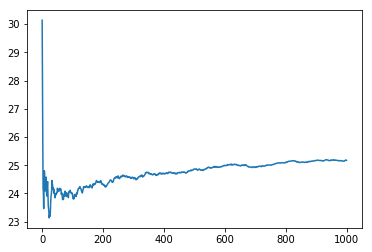

In [11]:
# Question 2
plt.plot(temperature_filter.estimates)

In [12]:
# Question 3
# Variance of 5 degrees in temperature, 10 in humidity
# Mean of 25 for temperature, 70 for humidity
data = np.random.randn(1000, 2) * [5, 10] + [25, 70]

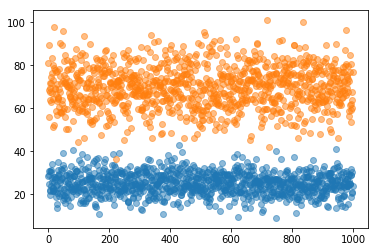

In [13]:
plt.plot(data, 'o', alpha=0.5)

In [14]:
original_estimate = np.array([30, 60])
estimated_measurement_error = np.array([5, 5])
original_estimated_error = np.array([2, 10])
weather_filter = KalmanFilter(original_estimate=original_estimate,
                              estimated_measurement_error=estimated_measurement_error,
                              original_estimated_error=original_estimated_error)

In [15]:
for row in data:
    weather_filter.update(row)

In [16]:
weather_filter.current_estimate

array([25.08804298, 69.89372506])

In [17]:
estimates = np.array(weather_filter.estimates)  # Convert to array so dimensional indexing works

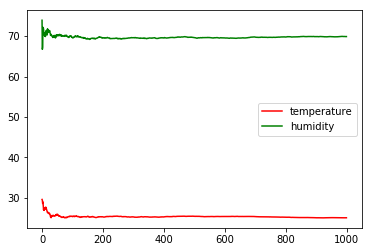

In [18]:
plt.plot(estimates[:,0], 'r-', label="temperature")
plt.plot(estimates[:,1], 'g-', label="humidity")
plt.legend()

In [19]:
weather_filter.current_error

array([0.00498502, 0.00499499])

### State transitions

Kalman filters can be extended to include state transitions. A common usage in the real world is for smoothing GPS data. In such data we get the estimated current position and the estimated velocity. In both cases, the values are estimates. GPS satellites move around and it can be hard for GPS systems to get a good fix on the data. Further, velocity is computed from position, so it also has a measurement error.

In this example, we have a transition from one state to another. Given a current state with a position and velocity, we can predict where the next position would be. We can then get actual data at our next time point, and the the Kalman filter can be used to smooth out the measurement error in this case.

Given a current state of:

$ X_t = [x, y, v_x, v_y]^T$

Where $(x, y)$ is the objects current position, $v_x$ is the velocity in the $x$ direction and $v_y$ is the velocity in the $y$ direction.




For this transition, we can predict the position at $X_{t+1}$ by adding the velocity to the position, with respect to how far into the future we are predicting.

States are updated according to the following general pattern:

$X_t = AX_{t-1} + Bu_{t} + w_t$

Where

* $A$ is a state change matrix. In our case, one that adds velocity to the old position
* $B$ is the control variable matrix, which accounts for added factors, such as the acceleration of an object (i.e. if we are tracking a falling object, this would account for gravity).
* $u_t$ is the control variable matrix 
* $w$ is the noise in the process. It is optional, but if properly modelled it can improve the results if used.


In the case of the above example, our state transition matrix looks like this:

$A = \begin{bmatrix}
1 & 0 & \Delta t & 0 \\
0 & 1 & 0 & \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}  $

Where $\Delta t$ is how much time it has been since we last updated the position.

Computing the dot product $AX_{t-1}$ will produce the new position and velocity $X_t$, if we assume that there is no velocity change. Velocity change is managed by the matrix product $Bu_t$.

For example if we had an object in free fall (and ignored wind resistance), it would be accelerating at a rate of $-9.8ms^2$. This would give $u_t = [0, -9.8]$. The matrix B would then be:

$B = \begin{bmatrix}
\frac{1}{2}\Delta t^2 & 0 \\
0 & \frac{1}{2}\Delta t^2 \\
\Delta t & 0 \\
0 & \Delta t
\end{bmatrix} $

For other systems, different state transition matrices $A$, $B$ and $u$ are needed, but they have the same responsibilities.

#### Exercise

Compute the state transition for an object being dropped in a vaccuum. The object starts 100m in the air and is dropped straight down.

* What are the values for the $X_{t-1}$, $A$, $B$ and $u_k$ values?
* What is the predicted position after 5 seconds?

Compute this both by hand (the number of computations is reasonably small but non-trivial) and also using NumPy, and compare the results.

With this computed, we can then receive new measurements, and update our model according to the computed Kalman Gain. While the computation is slightly different to the example at the start of this module, the general workflow is the same. We will look at some examples of this in the next module, as well as using a library for computing the Kalman Filter value, rather than by hand as we have in this module.

### An Example in stock price prediction

We will end this module with an example on stock price prediction using a Kalman filter. First, we will get some price data and compute the movements (rather than absolute prices). We are going to choose a stock with a long history and a seemingly stable price, and our theory is going to be that the stock is correctly valued and any major deviations will be corrected over time.

<div class="alert alert-warning">
    <p>
    There are a few Kalman filter libraries for python, including simdkalman and pyfilter. We have tested these and found them lacking in robustness and documentation, with some clear gaps in the libraries. Feel free to test them out, but note we haven't found a good, solid and reliable Kalman filter library.</p>
</div>

(-0.1, 0.1)

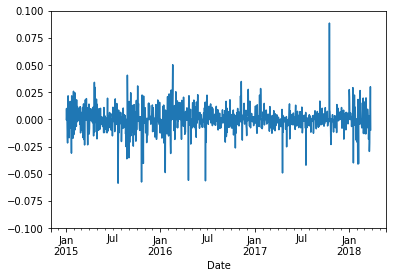

In [20]:
import quandl
import my_secrets
quandl.ApiConfig.api_key = my_secrets.QUANDL_API_KEY

stocks = quandl.get("WIKI/IBM")

stocks = stocks.asfreq('d')  # Set a frequency on the time series index

close = stocks['Adj. Close']

movement = close.pct_change().dropna()

fig = movement["2015":].plot()
fig.set_ylim(-0.1, 0.1)  # Note there are quite a few outliers, such as a 30% drop!

In [21]:
movement.mean()  # basically 0

movement = movement - movement.mean()  # Still, demean the data

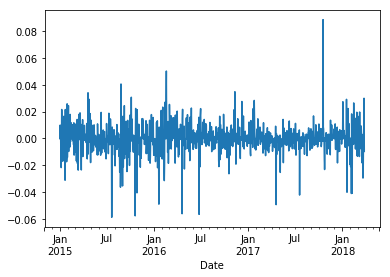

In [23]:
movement["2015":].plot()

In [73]:
mu = movement[:"2014"].mean()
std = np.sqrt(movement[:"2014"].std())

kf = KalmanFilter(original_estimate=1,
                 original_estimated_error=1,
                 estimated_measurement_error=std, 
                 process_variance_error=1e-3)

In [74]:
mu, std

(6.968591685742221e-06, 0.11821204178195706)

In [75]:
smoothed = pd.Series([kf.update(row) for row in movement], index=movement.index)

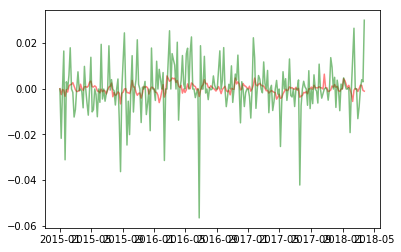

In [76]:
plt.plot(smoothed["2015":][::5], 'r-', alpha=0.5)
plt.plot(movement["2015":][::5], 'g-', alpha=0.5)

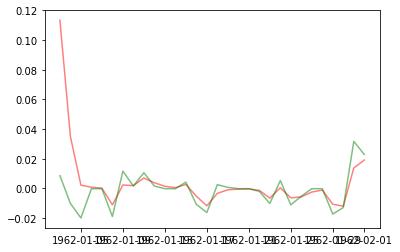

In [68]:
plt.plot(smoothed.head(30), 'r-', alpha=0.5)
plt.plot(movement.head(30), 'g-', alpha=0.5)

#### Extended Exercise

Modify the Kalman Filter code to include a predict function that can predict the next `n` timesteps in the series. To do this, predict the next value, use that as a data point for predicting the next one, and so on.

For an added challenge, ensure the function does not alter the internal state of the Kalman Filter instance. That is, you should be able to run your `predict` function twice and get the same result.